In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 23 16:18:16 PDT 2020


In [2]:
import vivarium_uw_covid as vuc

# Run university COVID sim with Wisconsin data from artifact


In [3]:
art_fname='src/vivarium_uw_covid/artifacts/wisc.hdf'
data = vuc.data_dict_from_artifact(art_fname)

Loading all COVID-19 projection data from src/vivarium_uw_covid/artifacts/wisc.hdf


In [4]:
beta_final = vuc.make_beta(data['coeffs'], data['df_covs'], data['beta_fit'])

# Run a simulation with monthly testing of an on-campus population of 30,000 and 50% mixing

In [5]:
n_draws = 12
start_time = pd.Timestamp('2020-09-14')
end_time = pd.Timestamp('2020-12-31')

In [6]:
alt_covs = vuc.make_alternative_covariates(
                data['df_covs'],
                start_time,
    
                mask_use=70/100,           # high level of masking
                mobility_reference=0,     # students move around a lot
            )
beta_alt_final = vuc.make_beta(data['coeffs'], alt_covs, data['beta_fit'])

In [7]:
n_on_campus = 30_000
mixing_parameter = 0.50

test_rate = (1 / 28)  # each person gets one test every four weeks, on average
tests_per_week = test_rate * 7 * n_on_campus
tests_per_week

7500.0

In [8]:
initial_states = data['compartment_sizes'].loc[start_time].dropna().set_index('draw')

In [9]:
%%time

np.random.seed(12345)  # set random seed for reproducilibity
df_individual_hybrid_dict, df_compartment_hybrid_dict = \
       vuc.run_hybrid_model(n_simulants=n_on_campus,
                         
                            mixing_parameter=mixing_parameter,
                            n_draws=n_draws,
                            beta_agent=beta_alt_final,
                            beta_compartment=beta_final,
                            
                            params=data['params'],
                            start_time=start_time,
                            end_time=end_time,
                            
                            initial_states_agent=initial_states,
                            initial_states_compartment=initial_states,
                            
                            use_mechanistic_testing=True,
                            test_rate=test_rate,
                            test_positive_rate=test_rate,
                            
                           )


CPU times: user 2min 25s, sys: 549 ms, total: 2min 25s
Wall time: 3min 39s



Cumulative infections on 12/11/20:
    1,599 (95% UI 720 to 4,109)



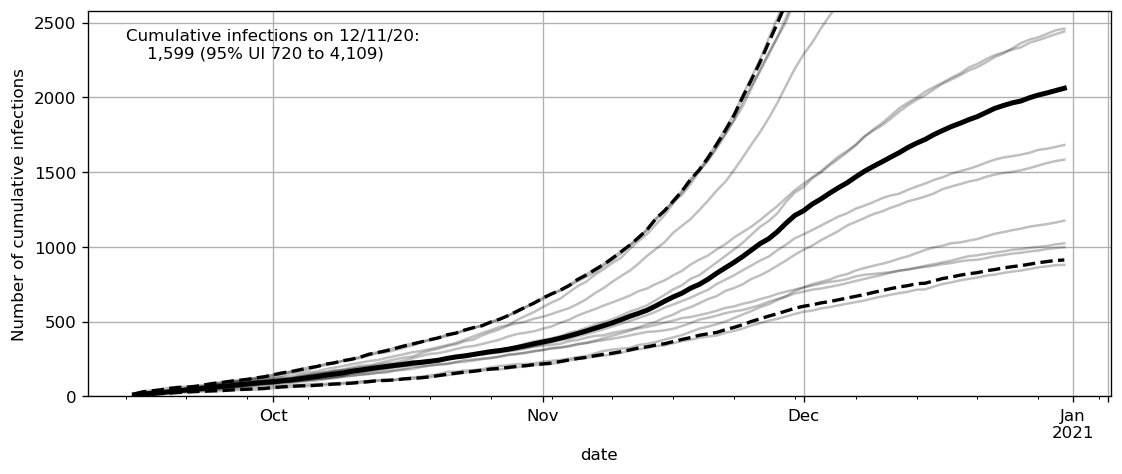

In [10]:
vuc.plot_results(df_individual_hybrid_dict,
                 metric='cumulative_infections')


Cumulative infections on 12/11/20:
    499,124 (95% UI 240,424 to 1,084,757)



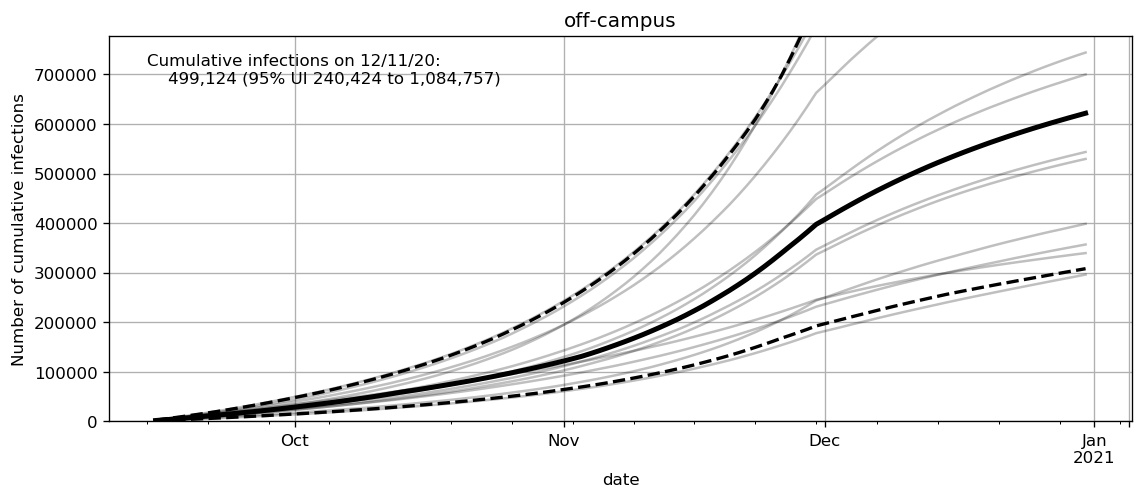

In [11]:
vuc.plot_results(df_compartment_hybrid_dict,
                 title='off-campus',
                 metric='cumulative_infections')